In [1]:
import numpy as np
import pandas as pd

from scipy import polyval, stats
import math
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.formula.api as sf
import statsmodels.api as sm

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams["font.family"] = "sans-serif"

In [3]:
df = pd.read_csv("../Tasks/Barcelona airbnb 10.2020.csv")

In [4]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,21974,Comf. double room/private bathroom,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37973,2.17631,Private room,55,3,2,2017-11-06,0.05,3,139
1,23197,Forum DeLuxe 5 mins Walk To CCIB Center & Sea★,90417,Etain (Marnie),Sant Martí,el Besòs i el Maresme,41.41291,2.22063,Entire home/apt,180,3,52,2019-12-15,0.45,2,358
2,32711,Sagrada Familia area - Còrsega 1,135703,Nick,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40566,2.17015,Entire home/apt,109,2,63,2020-02-22,0.56,5,0
3,34241,Private Double room - Plaza Real,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37916,2.17535,Private room,40,30,8,2013-07-15,0.06,3,0
4,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37978,2.17623,Entire home/apt,131,4,149,2020-03-11,1.22,3,92


In [5]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['id' 'host_id' 'latitude' 'longitude' 'price' 'minimum_nights'
 'number_of_reviews' 'reviews_per_month' 'calculated_host_listings_count'
 'availability_365']


                                  Shape and data types of the data

In [6]:
df.shape

(19896, 16)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19896 entries, 0 to 19895
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              19896 non-null  int64  
 1   name                            19884 non-null  object 
 2   host_id                         19896 non-null  int64  
 3   host_name                       19889 non-null  object 
 4   neighbourhood_group             19896 non-null  object 
 5   neighbourhood                   19896 non-null  object 
 6   latitude                        19896 non-null  float64
 7   longitude                       19896 non-null  float64
 8   room_type                       19896 non-null  object 
 9   price                           19896 non-null  int64  
 10  minimum_nights                  19896 non-null  int64  
 11  number_of_reviews               19896 non-null  int64  
 12  last_review                     

In [8]:
# Список долей отсутствующих записей для каждого признака
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

id - 0%
name - 0%
host_id - 0%
host_name - 0%
neighbourhood_group - 0%
neighbourhood - 0%
latitude - 0%
longitude - 0%
room_type - 0%
price - 0%
minimum_nights - 0%
number_of_reviews - 0%
last_review - 30%
reviews_per_month - 30%
calculated_host_listings_count - 0%
availability_365 - 0%


                                    Data cleaning

### Отсутствующие данные

In [9]:
df['name'] = df['name'].fillna('MISSING')
df['host_name'] = df['host_name'].fillna('MISSING')

In [10]:
# проверка заполнения недостающих значений 'name'
missing_df = df['name'].str.contains('MISSING')
df[missing_df]['name']

1869    MISSING
2285    MISSING
2685    MISSING
2698    MISSING
2804    MISSING
2890    MISSING
3001    MISSING
3012    MISSING
3358    MISSING
4533    MISSING
4561    MISSING
4661    MISSING
Name: name, dtype: object

<AxesSubplot:>

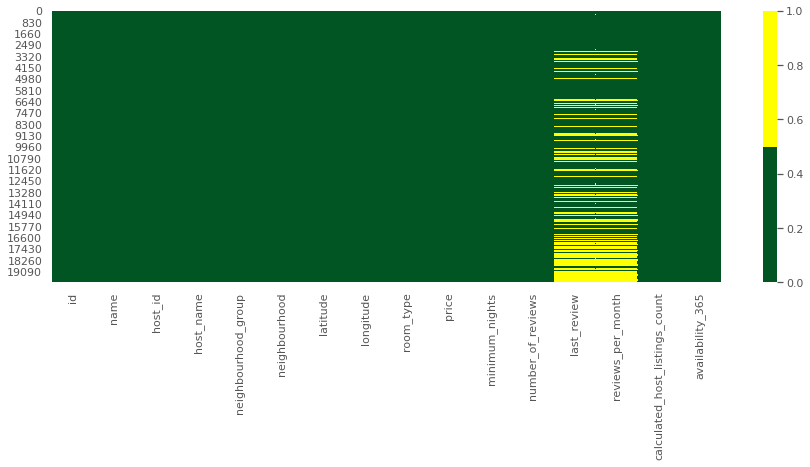

In [11]:
cols = df.columns
colours = ['#005522', '#ffff00']
# желтый - пропущенные данные
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

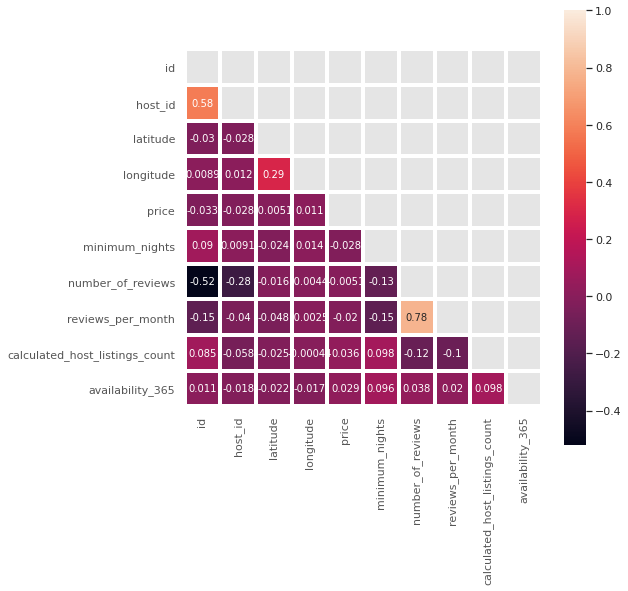

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
corr = df[[
    'id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
    'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count',
    'availability_365'
]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("dark"):
    ax = sns.heatmap(corr,
                     mask=mask,
                     square=True,
                     cbar=True,
                     annot=True,
                     linewidths=3)

In [13]:
#фильтр по пустым ячейкам в столбце reviews_per_month
filtered_nullable = df[df['reviews_per_month'].isnull()]
len(filtered_nullable)

5877

In [14]:
#выбор 2х столбцов по заданному фильтру
filtered_nullable = filtered_nullable[[
    'number_of_reviews', 'reviews_per_month'
]]
filtered_nullable['number_of_reviews'].value_counts()

0    5877
Name: number_of_reviews, dtype: int64

In [15]:
df['last_review'] = df['last_review'].fillna(0)
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [16]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

id - 0%
name - 0%
host_id - 0%
host_name - 0%
neighbourhood_group - 0%
neighbourhood - 0%
latitude - 0%
longitude - 0%
room_type - 0%
price - 0%
minimum_nights - 0%
number_of_reviews - 0%
last_review - 0%
reviews_per_month - 0%
calculated_host_listings_count - 0%
availability_365 - 0%


### Нетипичные данные (выбросы)

In [17]:
df['price'].describe()

count    19896.000000
mean        85.995074
std        207.216127
min          0.000000
25%         34.000000
50%         54.000000
75%         93.000000
max      10000.000000
Name: price, dtype: float64

In [18]:
df['price'].median()

54.0

In [19]:
df['price'].mode()[0]

50

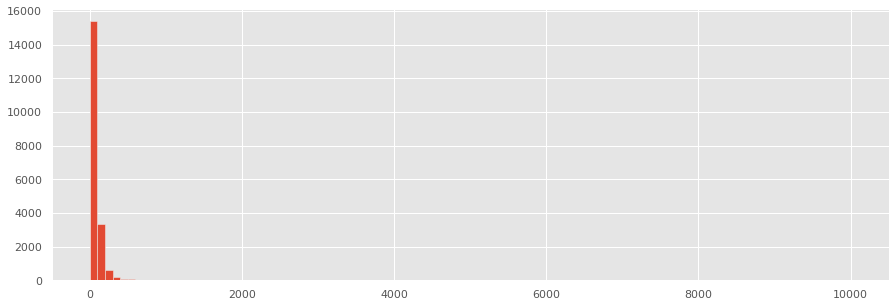

In [20]:
df['price'].hist(bins=100);

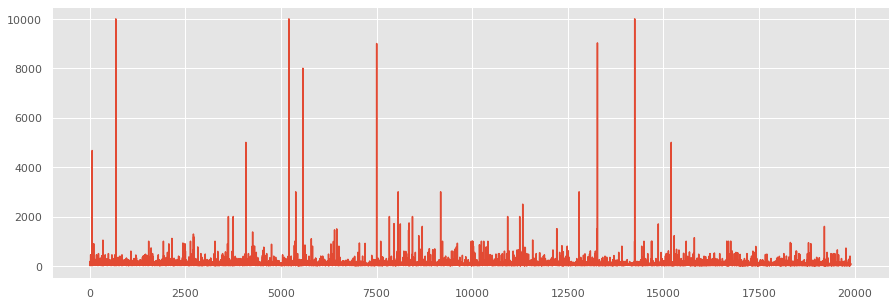

In [21]:
df["price"].plot();

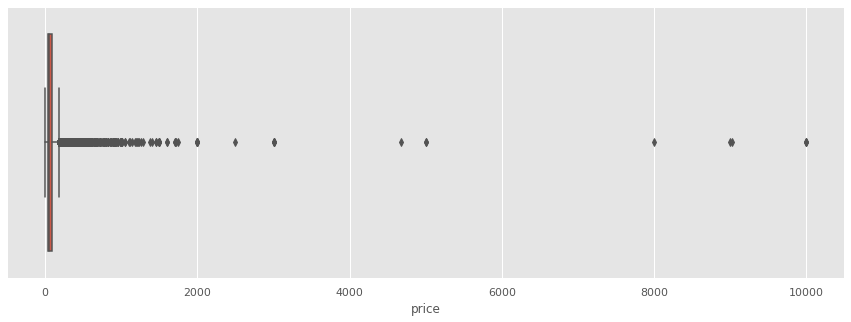

In [22]:
sns.boxplot(df['price'], orient="h");

In [23]:
# 1.5 межквартильных диапазона

df1 = df['price']
upper_quartile = np.percentile(df1, 75)
lower_quartile = np.percentile(df1, 25)
iqr = upper_quartile - lower_quartile  #Межквартильный диапазон
upper_whisker = df1[df1 <= upper_quartile + 1.5 * iqr].max()
upper_whisker

181

In [24]:
filtered_emissions = df[df['price'] > 181]
filtered_emissions

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
22,71520,Charming apartment with fantastic views!,366428,Ariadna,Gràcia,Vallcarca i els Penitents,41.41837,2.134190,Entire home/apt,250,5,1,2011-06-23,0.01,1,363
24,71603,MODERNIST PENTHOUSE. 1bedroom apt with terrace,366654,Watermen Barcelona Apartments,Eixample,la Dreta de l'Eixample,41.39038,2.176060,Entire home/apt,452,3,37,2019-06-02,0.31,7,365
30,73683,Sagrada Familia area for 12 people,135703,Nick,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40554,2.170170,Entire home/apt,218,2,164,2020-02-02,1.44,5,0
38,89756,"bcn-rentals.com nº 1, just 7-10 min to Ramblas",488117,David Y Maria,Ciutat Vella,el Raval,41.37815,2.168940,Entire home/apt,240,6,16,2019-10-19,0.17,7,355
64,158238,CENTRAL APARTMENT w/TERRASSE,759411,Raquel,Les Corts,les Corts,41.38416,2.136360,Entire home/apt,4670,2,116,2019-08-10,1.03,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19787,45668151,Casa Blanca,480528,Andrei,Sants-Montjuïc,la Marina del Prat Vermell,41.35204,2.148650,Entire home/apt,224,32,0,0,0.00,20,312
19788,45668287,Casa Flor,480528,Andrei,Sants-Montjuïc,la Marina del Prat Vermell,41.35323,2.146570,Entire home/apt,224,32,0,0,0.00,20,336
19843,45762959,Casa Amarilla,480528,Andrei,Sants-Montjuïc,Sants - Badal,41.37225,2.125490,Entire home/apt,269,32,0,0,0.00,20,342
19871,45794650,BE BARCELONA ARCO DEL TRIUNFO CENTRIC AND SWEET,40676061,Be Barcelona,Eixample,el Fort Pienc,41.39882,2.177280,Entire home/apt,200,1,0,0,0.00,19,365


In [25]:
# Объем нетипичных значений в данных
len(filtered_emissions) / len(df) * 100

7.03156413349417

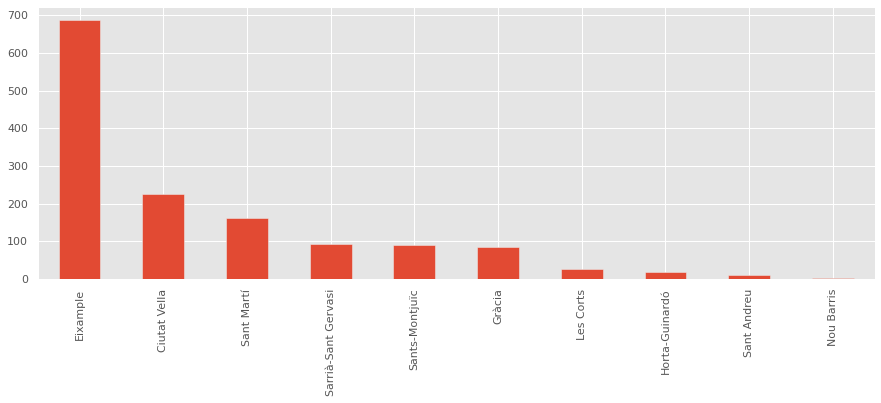

In [26]:
filtered_emissions['neighbourhood_group'].value_counts().plot.bar();

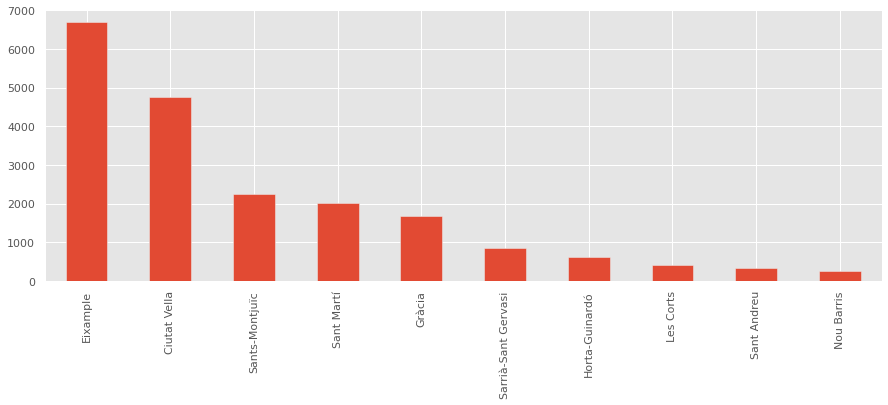

In [27]:
df['neighbourhood_group'].value_counts().plot.bar();

In [28]:
filtered_emissions['neighbourhood_group'].value_counts()

Eixample               687
Ciutat Vella           225
Sant Martí             162
Sarrià-Sant Gervasi     94
Sants-Montjuïc          89
Gràcia                  85
Les Corts               27
Horta-Guinardó          18
Sant Andreu             10
Nou Barris               2
Name: neighbourhood_group, dtype: int64

### Качество данных 

### Сдвиг данных

### Несогласованныe данныe – одни и тех же данные, представленные в разных регистрах или форматах.

### Неинформативные признаки

In [29]:
[k for k,v in Counter(df["id"]).items() if v>1]

[]

### Нерелевантные признаки

### Разные регистры символов

### Разные форматы данных

In [35]:
df['last_review_dt'] = pd.to_datetime(df['last_review'], format='%Y-%m-%d')
df['year'] = df['last_review_dt'].dt.year
df['month'] = df['last_review_dt'].dt.month
df['weekday'] = df['last_review_dt'].dt.weekday

In [31]:
df['name'] = df['name'].str.lower() #нижний регистр для всех строк
df['name'] = df['name'].str.strip() #удаление символов в начале и конце строки
df['name'] = df['name'].str.replace('\\.', '') #удаление точек
df['name'] = df['name'].str.replace('\\bstreet\\b', 'st') # введение сокращения

In [32]:
df.dtypes

id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                       object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                               object
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
last_review_dt                    datetime64[ns]
year                                       int64
month                                      int64
weekday                                    int64
dtype: object

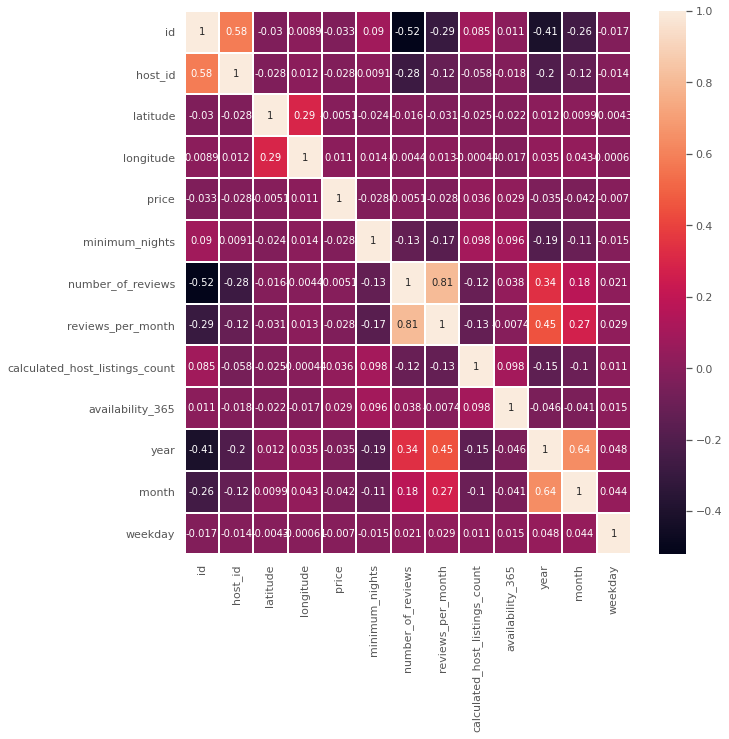

In [33]:
f, ax = plt.subplots( figsize=(10,10) )
sns.heatmap(df.corr(),annot=True,linewidths=1)
plt.show()